In [41]:
import pandas as pd
import eurostat

In [42]:
df = eurostat.get_data_df(code="PRC_HICP_MANR", filter_pars={
                          "geo": "fr", "coicop": ["FOOD", "NRG", "SERV", "IGD", "CP00"]})
df = df.rename(columns={'geo\TIME_PERIOD': 'geo'})

In [43]:
df = df.drop(['freq', 'unit', 'geo'], axis=1)

In [44]:
df = df.melt(id_vars=['coicop'], var_name='TIME_PERIOD',
             value_name='OBS_VALUE')

In [45]:
import matplotlib.pyplot as plt

In [46]:
import pandas as pd


url = "https://www.insee.fr/fr/statistiques/fichier/4648335/TF106.csv"

df_cons = pd.read_csv(url, sep=";")

In [47]:
df_cons = df_cons[df_cons['DECUC'] == 'TOT']

In [48]:
# renaming the "NOMENCLATURE" column to "FCOICOP"
df_cons = df_cons.rename(columns={'NOMENCLATURE': 'FCOICOP'})

In [49]:
# filtering out rows where the "FCOIC" value starts with "13"
df_cons = df_cons.loc[~df_cons['FCOICOP'].str.startswith('13')]

In [50]:
# loading the second csv file with the "FCOICOP" column
df2 = pd.read_csv('Nomenclature_classes_to_special_aggregates.csv')

In [51]:
# merging the two dataframes on the "FCOICOP" column
merged_df = pd.merge(df_cons, df2, on='FCOICOP')

In [52]:
sum_total = merged_df.groupby('DECUC')['CONSO'].sum()

In [53]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "DECUC" column
merged_df['PROP'] = merged_df['CONSO'] / merged_df['DECUC'].map(sum_total)

In [54]:
sum = merged_df.groupby('AGGREGATE')['PROP'].sum()

In [55]:
merged_df = df.merge(right=sum, left_on="coicop", right_on="AGGREGATE")

In [56]:
merged_df['inflation'] = merged_df['OBS_VALUE']*merged_df['PROP']

In [57]:
sum_inflation = merged_df.groupby('TIME_PERIOD')['inflation'].sum()

In [58]:
merged_df = merged_df.merge(right=sum_inflation, on="TIME_PERIOD")

In [59]:
merged_df['inflation'] = merged_df['inflation_x']/merged_df['inflation_y']

In [60]:
merged_df = merged_df[['coicop', 'TIME_PERIOD', 'inflation']]


In [61]:
merged_df = merged_df[merged_df['TIME_PERIOD'] >= '2021-03']


In [62]:
merged_df = merged_df[merged_df['TIME_PERIOD'] <= '2023-03']


In [63]:
df = merged_df.pivot(index='TIME_PERIOD', columns='coicop', values='inflation')


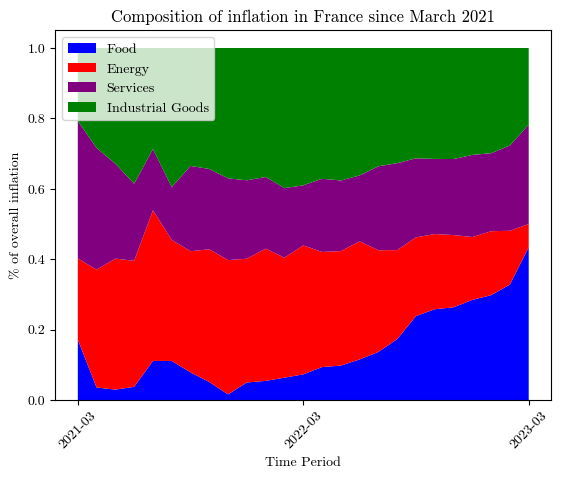

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


time_period = df.index
food = df['FOOD']
nrg = df['NRG']
serv = df['SERV']
igd = df['IGD']

colors = ['blue', 'red', 'purple', 'green']
labels = ['Food', 'Energy', 'Services', 'Industrial Goods']

plt.stackplot(time_period, food, nrg, serv, igd, labels=labels, colors=colors)

plt.xlabel('Time Period')
plt.ylabel('% of overall inflation')
plt.title('Composition of inflation in France since March 2021')
plt.legend(loc='upper left')

ticks = np.arange(0, len(time_period), 12)  
labels = [time_period[i] for i in ticks]  
plt.xticks(ticks, labels, rotation=45)  

plt.rcParams['font.family'] = 'cmr10'
plt.savefig('saved_figs/figure29.png', dpi=500, bbox_inches='tight')
plt.show()